In [2]:
import sys
import numpy as np
from matplotlib.pyplot import hist
import datetime
from sklearn import metrics

sys.path.insert(0, '/Users/jmcallister/repos/fat-stacks')
from data.data_utils import load_kraken_data
from models.model_utils import perc_change, trinary_labels
from models.features import HourlySMA
from models.model import XGBoostV0, MLPClassifierV0
from models.labels import BinaryLabels, TrinaryLabels

In [3]:
df = load_kraken_data("XBT", "USD", 15)
df = df[df["Date"] >= datetime.datetime(2017, 1, 1)]
prices = df["Close"].to_numpy()
perc = perc_change(prices)

(array([0.0000e+00, 2.0000e+00, 4.0000e+00, 1.4000e+01, 2.1000e+01,
        4.0000e+01, 1.1600e+02, 4.9700e+02, 2.9630e+03, 7.7029e+04,
        8.1829e+04, 2.8650e+03, 4.0200e+02, 1.1700e+02, 4.3000e+01,
        2.7000e+01, 9.0000e+00, 2.0000e+00, 5.0000e+00]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <BarContainer object of 19 artists>)

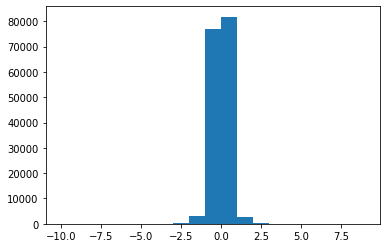

In [4]:
hist(perc * 100, bins = list(range(-10,10,1)))

(array([53154.,     0.,     0.,     0.,     0., 57337.,     0.,     0.,
            0., 55501.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

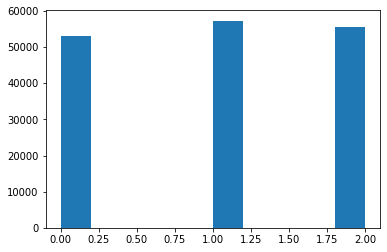

In [5]:
hist(trinary_labels(prices, threshold=0.001)[1:])

In [ ]:
df = load_kraken_data("XBT", "USD", 60)
df = df[df["Date"] >= datetime.datetime(2020, 1, 1)]
feature_store = HourlySMA()
model = XGBoostV0(df, feature_store, TrinaryLabels(0.001), "hourly_sma_mlp")
period = feature_store.get_period()
assert feature_store.get_features(df).shape[0] == df[period:].shape[0]
model.train()
assert len(model.x_train) + len(model.x_test) == df[period:].shape[0] - 2

labels = model.get_labels()
possible_labels = np.unique(labels)
common_guess_baseline = 0
for label in possible_labels:
    perc_dist =  len(labels[labels == label]) / len(labels)
    if perc_dist > common_guess_baseline:
        common_guess_baseline = perc_dist
print("Baseline Accuracy {}: ".format(common_guess_baseline))

y_test_pred = model.infer(model.x_test)
y_train_pred = model.infer(model.x_train)
print("Train Accuracy:", metrics.accuracy_score(model.y_train, y_train_pred))
print("Test Accuracy:", metrics.accuracy_score(model.y_test, y_test_pred))
assert metrics.accuracy_score(model.y_train, y_train_pred) > common_guess_baseline, "Does not outperform baseline on train set"
assert metrics.accuracy_score(model.y_test, y_test_pred) > common_guess_baseline, "Does not outperform baseline on test set"